In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import string
from functools import reduce
import random
from tqdm import tqdm
from time import sleep

# Data Downloading

In [3]:
# %pip install kaggle --upgrade
# !kaggle competitions download -c english-phonetics-2019

In [7]:
# import zipfile 

# def unzip(zip_filename: str, dst_dir: str = './'):
#     with zipfile.ZipFile(zip_filename, 'r') as zf:
#         for entry in tqdm(zf.infolist(), desc='Extracting '):
#             try:
#                 zf.extract(entry, dst_dir)
#             except zipfile.error as e:
#                 print(e)
#                 pass

# unzip('english-phonetics-2019.zip')

# Data Loading and Preprocessing

In [8]:
with open('train.txt', encoding='utf-8') as f:
    train = [np.array(line.split()) for line in f]
    
train[:5]

[array(['LEMIEUX', 'L_AH_M_Y_UW'], dtype='<U11'),
 array(['MINDING', 'M_AY_N_D_IH_NG'], dtype='<U14'),
 array(['STRIPED', 'S_T_R_AY_P_T'], dtype='<U12'),
 array(['KEN', 'K_EH_N'], dtype='<U6'),
 array(['CONFERENCE', 'K_AA_N_F_ER_AH_N_S', 'K_AA_N_F_R_AH_N_S'],
       dtype='<U18')]

In [9]:
%%time
train = list(map(lambda arr: [[arr[0], arr[i]] for i in range(1, len(arr))], train))
train = np.array(list(reduce(lambda t0, t1: t0 + t1, train)))

train[:6]

Wall time: 2min 29s


array([['LEMIEUX', 'L_AH_M_Y_UW'],
       ['MINDING', 'M_AY_N_D_IH_NG'],
       ['STRIPED', 'S_T_R_AY_P_T'],
       ['KEN', 'K_EH_N'],
       ['CONFERENCE', 'K_AA_N_F_ER_AH_N_S'],
       ['CONFERENCE', 'K_AA_N_F_R_AH_N_S']], dtype='<U79')

In [10]:
test = pd.read_csv('test.csv', index_col = 0)
test

,Word
Id,
1,PITCHED
2,DISSOLVERS
3,SCRAWNY
4,BONENFANT
5,EXCEEDS
...,...
41593,INOCULATION
41594,UNTO
41595,SCOGIN


# Data Preparation and Encoding

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [23]:
test.Word.map(len).max()

20

In [20]:
MAX_WORD_LENGTH = max(list(map(len, train[:, 0]))) + 1
                # max length of a word in train
                #   +
                # end token
MAX_WORD_LENGTH

35

In [21]:
MAX_TRANSCRIPTION_LENGTH = max(list(map(lambda t: len(t.split('_')), train[:, 1]))) + 1 + 1
                # max length of a transcription in train
                #   +
                # start token
                #   +
                # end token
MAX_TRANSCRIPTION_LENGTH

34

In [22]:
MAX_LENGTH = 35

In [24]:
np.sort(list(set("".join(train[:, 0]))))

array(["'", '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
       'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z'], dtype='<U1')

In [26]:
all_letters = np.sort(list(set("".join(train[:, 0]))))
end_letter = 'Z&'
all_letters = np.sort(np.append(all_letters, end_letter))
print(all_letters, all_letters.size)

["'" '-' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P'
 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'Z&'] 29


In [30]:
n_letters = len(all_letters)

def letterToIndex(letter):
    return int(all_letters.searchsorted(letter))

def lineToIndices(line):
    tensor = torch.zeros(len(line) + 1).type(torch.LongTensor).to(device)
    for i, l in enumerate(line):
        tensor[i] = letterToIndex(l)
    tensor[-1] = letterToIndex(end_letter)
    return tensor

def indicesToLine(indices):
    return "".join([all_letters[ind] for ind in indices][:-1])

sample_ = train[0][0]
print(sample_)
print(lineToIndices(sample_), lineToIndices(sample_).size())
print(indicesToLine(lineToIndices(sample_)))

LEMIEUX
tensor([13,  6, 14, 10,  6, 22, 25, 28]) torch.Size([8])
LEMIEUX


In [29]:
categories = list(reduce(lambda t0, t1: list(set(t0 + t1)), [t.split('_') for t in train[:, 1]]))
start_token = '###'
end_token = 'ZZ$'
categories = np.sort(np.append(categories, (start_token, end_token)))
print(categories, categories.size)

['###' 'AA' 'AE' 'AH' 'AO' 'AW' 'AY' 'B' 'CH' 'D' 'DH' 'EH' 'ER' 'EY' 'F'
 'G' 'HH' 'IH' 'IY' 'JH' 'K' 'L' 'M' 'N' 'NG' 'OW' 'OY' 'P' 'R' 'S' 'SH'
 'T' 'TH' 'UH' 'UW' 'V' 'W' 'Y' 'Z' 'ZH' 'ZZ$'] 41


In [ ]:
phonemes = transcription.split('_')
        tensor = torch.from_numpy(np.array([self.phoneme2index(self.start_phoneme)] + \
                        [self.phoneme2index(ph) for ph in phonemes] + [self.phoneme2index(self.end_phoneme)]))
        tensor = tensor.type(torch.LongTensor).to(self.device)
        return tensor

In [34]:
n_categories = len(categories)

def categoryToIndex(cat):
    return categories.searchsorted(cat)

def categoriesToIndices(line):
    arr = line.split('_')
    tensor = torch.zeros(len(arr) + 2)
    tensor[0] = torch.tensor(categoryToIndex(start_token))
    for li, cat in enumerate(arr):
        tensor[li + 1] = torch.tensor(categoryToIndex(cat))
    tensor[-1] = torch.tensor(categoryToIndex(end_token))
    return tensor.type(torch.LongTensor).to(device)

def indicesToCategories(indices):
    return "_".join([categories[ind] for ind in indices][1:-1])

def startToken():
    return torch.tensor([categoryToIndex(start_token)]).type(torch.LongTensor).to(device)

def endToken():
    return torch.tensor([categoryToIndex(end_token)]).type(torch.LongTensor).to(device)

sample_ = train[0][1]
print(sample_)
print(categoriesToIndices(sample_), categoriesToIndices(sample_).size())
print(indicesToCategories(categoriesToIndices(sample_)))
print(startToken())
print(endToken())

L_AH_M_Y_UW
tensor([ 0, 21,  3, 22, 37, 34, 40]) torch.Size([7])
L_AH_M_Y_UW
tensor([0])
tensor([40])


# RNN Decoder and Decoder

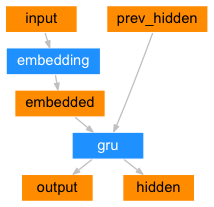

In [33]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device = device)
    
n_hidden = 128
en = EncoderRNN(n_letters, n_hidden)
en.to(device)

EncoderRNN(
  (embedding): Embedding(29, 128)
  (gru): GRU(128, 128)
)

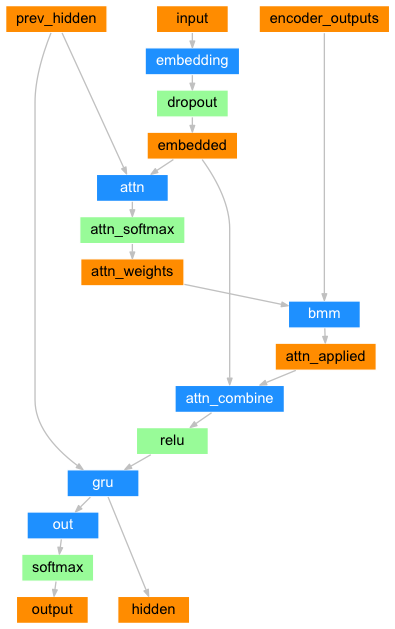

In [52]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p = 0.1, max_length = MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim = 1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
n_hidden = 128
de = AttnDecoderRNN(n_hidden, n_categories)
de.to(device)

AttnDecoderRNN(
  (embedding): Embedding(41, 128)
  (attn): Linear(in_features=256, out_features=34, bias=True)
  (attn_combine): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.1)
  (gru): GRU(128, 128)
  (out): Linear(in_features=128, out_features=41, bias=True)
)

# Model Training and Evaluation

In [24]:
teacher_forcing_ratio = 0.5
endTensor = endToken()

def Train(input_tensor, target_tensor):
    en_hidden = en.initHidden()

    en_optimizer.zero_grad()
    de_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    en_outputs = torch.zeros(MAX_LENGTH, en.hidden_size, device = device)
    
    loss = 0
    
    for ei in range(input_length):
        en_output, en_hidden = en(input_tensor[ei], en_hidden)
        en_outputs[ei] = en_output.view(-1,)

    de_input = startToken()

    de_hidden = en_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for di in range(target_length):
            de_output, de_hidden, de_attention = de(de_input, de_hidden, en_outputs)
            loss += criterion(de_output, target_tensor[di])
            de_input = target_tensor[di] 
    else:
        for di in range(target_length):
            de_output, de_hidden, de_attention = de(de_input, de_hidden, en_outputs)
            topv, topi = de_output.topk(1)
            de_input = topi.squeeze().detach()  # detach from history

            loss += criterion(de_output, target_tensor[di])
            if de_input.item() == endTensor.item():
                break

    loss.backward()

    en_optimizer.step()
    de_optimizer.step()

    return loss.item() / target_length

In [12]:
def Transcript(input_tensor):
    with torch.no_grad():       
        input_length = input_tensor.size()[0]
        en_hidden = en.initHidden()

        en_outputs = torch.zeros(MAX_LENGTH, en.hidden_size, device = device)

        for ei in range(input_length):
            en_output, en_hidden = en(input_tensor[ei], en_hidden)
            en_outputs[ei] += en_output[0, 0]

        de_input = startToken()

        de_hidden = en_hidden

        decoded_categories = []

        for di in range(MAX_LENGTH):
            de_output, de_hidden, de_attention = de(de_input, de_hidden, en_outputs)
            topv, topi = de_output.data.topk(1)
            decoded_categories.append(topi.item())

            if topi.item() == endTensor.item():
                break
            decoder_input = topi.squeeze().detach()

        return decoded_categories

In [13]:
def Test(input_tensor, target_tensor):
    output = np.array(Transcript(input_tensor))
    target = target_tensor.data.numpy()
    return int(np.array_equal(output, target))

In [53]:
criterion = nn.NLLLoss()
epochs_num = 5
results = []

In [58]:
for epoch in range(epochs_num):
    print('epoch:', epoch + 1)
    rates = [1e-2, 1e-3, 1e-3, 1e-4, 1e-4]
    learning_rate = rates[epoch]
    en_optimizer = torch.optim.SGD(en.parameters(), lr = learning_rate)
    de_optimizer = torch.optim.SGD(de.parameters(), lr = learning_rate)
    samples_num = 50000
    step = samples_num // 100
    for i in range(s, samples_num):
        input_tensor, target_tensor = lineToIndices(train[i][0]), categoriesToIndices(train[i][1]).view(-1,1)
        loss = Train(input_tensor, target_tensor)
        if not i % step:
            print(i)
        if not i % (step * 10):
            print(i, loss, Transcript(lineToIndices(train[i][0])),categoriesToIndices(train[i][1]))
    print('evaluation...')
    sum = 0
    num = 1000
    print(Transcript(lineToIndices(train[i][0])), categoriesToIndices(train[i][1]))
    for i in  range(samples_num, samples_num + num):
        input_tensor, target_tensor = lineToIndices(train[i][0]), categoriesToIndices(train[i][1])
        sum += Test(input_tensor, target_tensor)
    print(sum/num)
    print(Transcript(lineToIndices(train[i][0])), categoriesToIndices(train[i][1]))
    results = np.append(results, sum/num)

epoch: 1
36000
36500
37000
37500
38000
38500
39000
39500
40000
40000 0.6920232772827148 [0, 27, 21, 5, 9, 40] tensor([ 0, 27, 21,  5,  9, 40])
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45000 0.6361077853611538 [0, 35, 3, 31, 17, 24, 24, 40] tensor([ 0, 35, 25, 31, 17, 24, 40])
45500
46000
46500
47000
47500
48000
48500
49000
49500
evaluation...
[0, 22, 12, 28, 40] tensor([ 0, 22, 12, 14, 40])
0.09
[0, 9, 17, 28, 17, 20, 31, 31, 31, 40] tensor([ 0,  9,  6, 28, 11, 20, 31, 17, 35, 38, 40])
epoch: 2
0
0 1.664879662649972 [0, 21, 11, 22, 17, 34, 20, 20, 40] tensor([ 0, 21,  3, 22, 37, 34, 40])
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5000 0.3553908348083496 [0, 36, 18, 29, 40] tensor([ 0, 36, 18, 38, 40])
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10000 1.651793638865153 [0, 22, 17, 29, 3, 23, 23, 23, 40] tensor([ 0, 22, 17, 29, 31, 13, 31, 22,  3, 23, 31, 40])
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15000 0.503299331665039 [0, 11, 27, 2

KeyboardInterrupt: 

In [17]:
for i in range(results.size):
    print('epoch:', i+1, 'results:', results[i])

epoch: 1 results: 0.2372
epoch: 2 results: 0.2915
epoch: 3 results: 0.39245


In [161]:
#torch.save(de, 'decoder_34')
#torch.save(en, 'encoder_34')

# Submission Making

In [198]:
words = []
for i, t in enumerate(test.values.reshape(-1,)):
    if not i % 1000:
        print(i)
    with torch.no_grad():
        input = lineToTensor(t)
        input = input.to(device)
        hidden = en(input)
        output, hidden = de(startTensor, hidden)
        outputs = []
        for _ in range(MAX_LENGTH):
            output, hidden = de(output, hidden)
            outputs = np.append(outputs, output.argmax().item())
            if (output.argmax().item() == endTensor.item()):
                break
        words = np.append(words, tensorToCategories(torch.from_numpy(outputs).type(torch.LongTensor)))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000


In [203]:
_predictions = words.reshape(words.size,)
with open('predictions.csv', 'w') as out:
    print('id,word', file=out)
    for i, p in enumerate(_predictions):
        print(i+1, p, sep=',', file=out)

In [204]:
preds = pd.read_csv('predictions.csv').values[:,1]